<h1>NetworkX Demo</h1>

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt

import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex

from IPython.display import display
from lda_for_fragments import Ms2Lda
from visualisation.networkx.lda_visualisation import *

# get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>1. Load Data and apply thresholding</h2>

Load Beer3pos project used by Justin and apply thresholding below.

In [13]:
ms2lda = Ms2Lda.resume_from('results/Manuscript_Beer3POSmode_EFassigner_ALLextended.project')

Project loaded from results/Manuscript_Beer3POSmode_EFassigner_ALLextended.project time taken = 21.4149539471
 - input_filenames = 
	../input/manuscript/Beer3pos_MS1filter_Method3_fragments.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_losses.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms1.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = 11/30/15 16:11:30
 - message = Beer3Pos analysis for the manuscript with EFassigner EF assignments for ms1, fragments, and losses


In [14]:
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

<h2>2. Create network graph</h2>

Specify the list of motifs of interest below. 

In [15]:
# all the highest-confidence motifs
# motifs_of_interest = [260, 262, 226, 158, 243, 127, 174, 59, 
#                       214, 60, 151, 40, 284, 276, 45, 79, 184, 
#                       130, 220, 55, 241, 13, 115, 162, 19, 58, 
#                       202, 131, 129, 222, 230, 67, 42, 116]

# smaller list
motifs_of_interest = [262, 158, 220, 55, 241, 115, 202, 226, 22, 58, 19]

In [16]:
G = get_network_graph(ms2lda, motifs_of_interest)
print "\n" + nx.info(G)

Removed 289 motifs from the graph because they're not in the list
Removed ['motif_22'] from the graph because they don't share documents with other motifs in the list
Removed 1099 unconnected documents from the graph

Name: 
Type: Graph
Number of nodes: 333
Number of edges: 357
Average degree:   2.1441


So, when we create the graph *G*, we also filtered it in such a way that (1) only the motifs in the provided list are retained and additionally, (2) these motifs must have some documents shared with another motif.

Next, we draw a bipartite graph where the left side is the MS1 peaks (labelled by their peak ids) and the right side are the M2Ms. The graph has been filtered such that we only show MS1 peaks that are connected to at least *min_degree* number of Mass2Motifs. 

The number beside each motif (e.g. +25) shows how many other MS1 connected to it that we are not showing because there's no overlap with other motifs in the list.

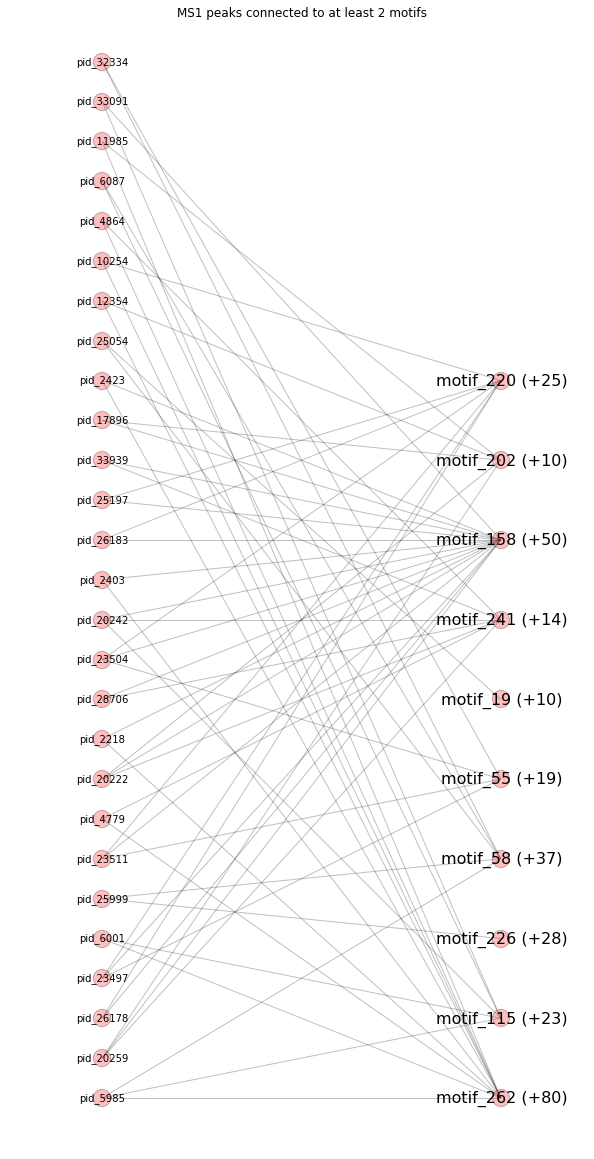

In [17]:
doc_nodes, doc_motifs, motif_idx = plot_bipartite(G, min_degree=2, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

# can tweak the fig_ and spacing_ parameters to adjust the plot appearance, especially if graph is dense
# doc_nodes, doc_motifs, motif_idx = plot_bipartite(G, min_degree=3, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

We can also plot the fragmentation spectra of these MS1 peaks of interest, coloring their MS2 peaks by the motifs. First, we set up some objects that would be used later.

In [18]:
# find out which words belong to which M2M
word_map, motif_words = ms2lda.print_motif_features(selected_motifs=motifs_of_interest, quiet=True)

# read CSV annotation
motif_annotation = {}
for item in csv.reader(open("results/beer3pos_annotation.csv"), skipinitialspace=True):
    key = int(item[0])
    val = item[1]
    motif_annotation[key] = val
    
# map each motif to the colourmap too
# http://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.hires.png
norm = mpl.colors.Normalize(vmin=min(motif_idx.values()), vmax=max(motif_idx.values()))
cmap = cm.gist_rainbow
motif_colour = cm.ScalarMappable(norm=norm, cmap=cmap)

In [19]:
def get_colour(m2m, motif_idx, motif_colour):
    try:
        word_colour = motif_colour.to_rgba(motif_idx[m2m])
    except AttributeError:
        word_colour = motif_colour[m2m]
    return word_colour

def plot_fragmentation_spectrum(ms2_df, ms1_row, motif_colour, motif_idx, 
                                ms1_label=None, save_to=None, xlim_upper=300):
    
    # make sure that the fragment and loss words got plotted first in the loop below
    ms2_df = ms2_df.fillna(value=np.NaN)
    ms2_df.sort_values('fragment_motif', ascending=True, inplace=True, na_position='first')
    
    # set figure and font sizes
    plt.figure(figsize=(20, 10), dpi=900)
    ax = plt.subplot(111)
    large_font_size = 32
    small_font_size = 24
    linewidth = 4

    # the ms1 info
    ms1_peakid = ms1_row['peakID'].values[0]
    ms1_mz = ms1_row['mz'].values[0]    
    ms1_rt = ms1_row['rt'].values[0]
    ms1_intensity = ms1_row['intensity'].values[0]
    ms1_annotation = ms1_row['annotation'].values[0]    
    
    # hacky
    neutral_loss_positions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    neutral_loss_count = 0

    # plot each MS2 peak    
    for row_index, row in ms2_df.iterrows():

        mz = row['ms2_mz']
        intensity = row['ms2_intensity']    
        frag_m2m = row['fragment_motif']
        loss_m2m = row['loss_motif']
        frag_word = row['fragment_word']
        loss_word = row['loss_word']
        
        if not np.isnan(loss_m2m):

            # draw neutral loss arrow
            word_colour = get_colour(loss_m2m, motif_idx, motif_colour)
            arrow_x1 = ms1_mz
            arrow_y1 = neutral_loss_positions[neutral_loss_count]
            arrow_x2 = (mz-ms1_mz)+5
            arrow_y2 = 0
            neutral_loss_count += 1
            plt.arrow(arrow_x1, arrow_y1, arrow_x2, arrow_y2, head_width=0.05, head_length=4.0, width=0.005, fc=word_colour, ec=word_colour)

            # draw neutral loss label
#             text_x = mz+(ms1_mz-mz)/4
#             text_y = arrow_y1+0.025
#             t = ax.text(text_x, text_y, loss_word.split('_')[1], ha="left", va="center", rotation=0,
#                         size=small_font_size, color=word_colour)

        # draw the fragment
        if not np.isnan(frag_m2m):
            word_colour = get_colour(frag_m2m, motif_idx, motif_colour)            
#             if intensity > 0.2:
#                 ax.text(mz, intensity+0.025, frag_word.split('_')[1], ha="center", va="center", 
#                         size=small_font_size, color=word_colour)
        else:
            word_colour = 'lightgray'
        plt.plot((mz, mz), (0, intensity), linewidth=linewidth, color=word_colour)

    # plot the ms1 peak too
    plt.plot((ms1_mz, ms1_mz), (0, 0.25), linewidth=linewidth, color='k')
    plt_label = "MS1 mz=%.4f RT=%.2f" % (ms1_mz, ms1_rt)
    ax.text(ms1_mz+2, 0.38, plt_label, ha="left", va="center", 
            size=small_font_size, color='k', rotation=90)

    # set title, axes labels and ranges
    if ms1_label is not None and ms1_peakid in ms1_label:
        ms1_annotation += "; " + ms1_label[ms1_peakid]
    title = "Fragmentation spectrum for MS1 peakID %d (%s)" % (ms1_peakid, ms1_annotation)    
    plt.title(title)
    plt.xlabel('m/z')
    plt.ylabel('Relative Intensity')
    plt.xlim([0, ms1_mz + 100])    
    plt.ylim([0, 1.1])

    # plot legend
    fragment_m2m = ms2_df['fragment_motif'].values
    fragment_m2m = set(fragment_m2m[~np.isnan(fragment_m2m)].tolist())
    loss_m2m = ms2_df['loss_motif'].values
    loss_m2m = set(loss_m2m[~np.isnan(loss_m2m)].tolist())
    m2m_used = fragment_m2m | loss_m2m
    m2m_patches = []
    for m2m in m2m_used:
        m2m_colour = get_colour(m2m, motif_idx, motif_colour)        
        m2m_patch = mpatches.Patch(color=m2m_colour, label='M2M_%d' % m2m)
        m2m_patches.append(m2m_patch)
    ax.legend(handles=m2m_patches, loc='upper right', 
              ncol=1, fancybox=True, shadow=True, prop={'size': large_font_size})        

    # increase fontsize
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(large_font_size)    

    # save figure
    if save_to is not None:
        print "Figure saved to %s" % save_to
        plt.savefig(save_to, bbox_inches='tight')
    plt.show()

<h2>4. Example</h2>

Using motif 58 and 19 as suggested by Justin

In [20]:
# check their respective peak IDs and see if any overlap
peak_ids1 = get_peak_ids_of_m2m(G, 58)
peak_ids2 = get_peak_ids_of_m2m(G, 19)
overlap = peak_ids1.intersection(peak_ids2)

print peak_ids1
print
print peak_ids2
print
print overlap

set([33793, 4331, 2820, 2951, 31468, 23564, 25999, 34065, 2967, 4378, 14239, 4260, 6063, 1073, 25267, 4276, 33722, 16063, 16126, 4427, 18756, 6087, 26995, 34381, 1102, 33108, 32334, 31830, 34391, 2852, 16092, 1117, 25054, 5985, 4587, 33516, 31346, 25075, 4341, 1087, 7676, 25086])

set([33376, 18337, 9034, 9259, 9071, 23984, 33815, 30232, 33851, 24157, 25054])

set([25054])


 - M2M_58	: Phenylacetaldehyde substructure (benzene ring with ethanol group attached)
		  fragment_121.06489 (0.412),fragment_103.05448 (0.103),fragment_93.06981 (0.082),fragment_53.03888 (0.080),fragment_91.05413 (0.071),fragment_152.10755 (0.027),loss_68.02601 (0.026),fragment_138.05067 (0.023),fragment_166.12292 (0.023),fragment_95.04936 (0.013),
 - M2M_19	: Ferulic acid based substructure
		  fragment_177.05475 (0.191),fragment_89.03864 (0.146),fragment_145.02839 (0.137),fragment_117.03316 (0.115),fragment_364.22203 (0.035),fragment_149.05998 (0.028),fragment_307.17496 (0.027),loss_137.08402 (0.024),loss_130.12154 (0.024),loss_193.07267 (0.016),loss_176.10859 (0.016),fragment_100.07536 (0.013),fragment_171.1487 (0.012),fragment_134.03657 (0.012),fragment_78.04655 (0.011),fragment_234.11111 (0.011),

Figure saved to figure_9a.pdf


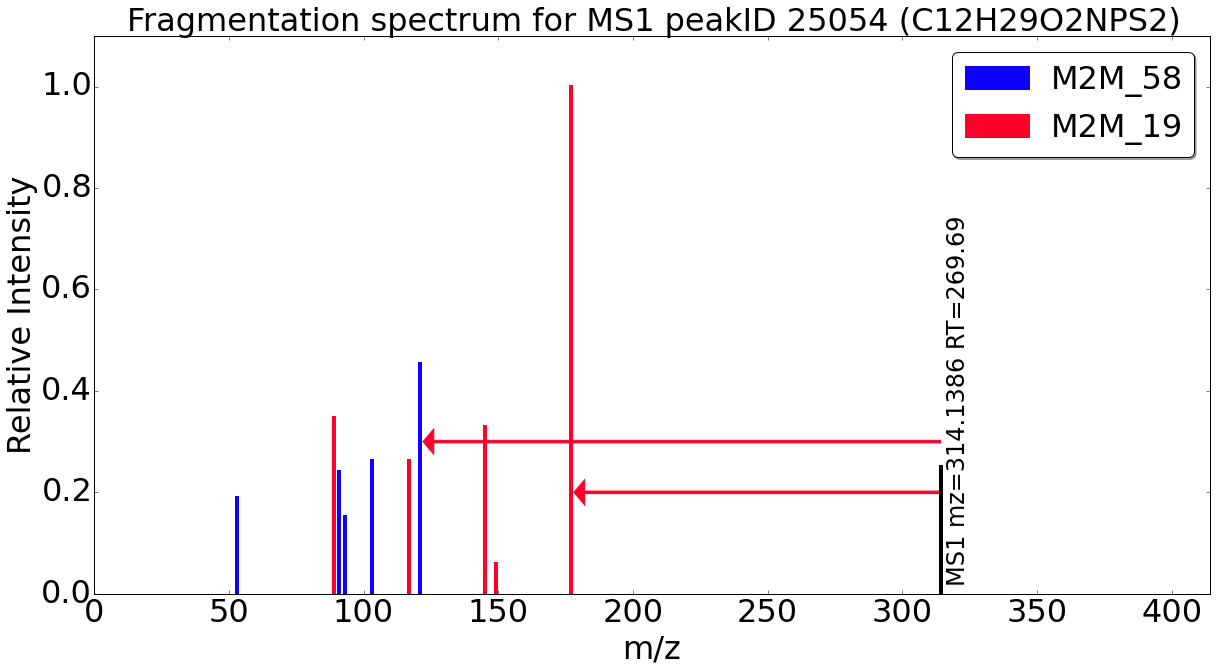

 - M2M_58	: Phenylacetaldehyde substructure (benzene ring with ethanol group attached)
		  fragment_121.06489 (0.412),fragment_103.05448 (0.103),fragment_93.06981 (0.082),fragment_53.03888 (0.080),fragment_91.05413 (0.071),fragment_152.10755 (0.027),loss_68.02601 (0.026),fragment_138.05067 (0.023),fragment_166.12292 (0.023),fragment_95.04936 (0.013),

Figure saved to figure_9b.pdf


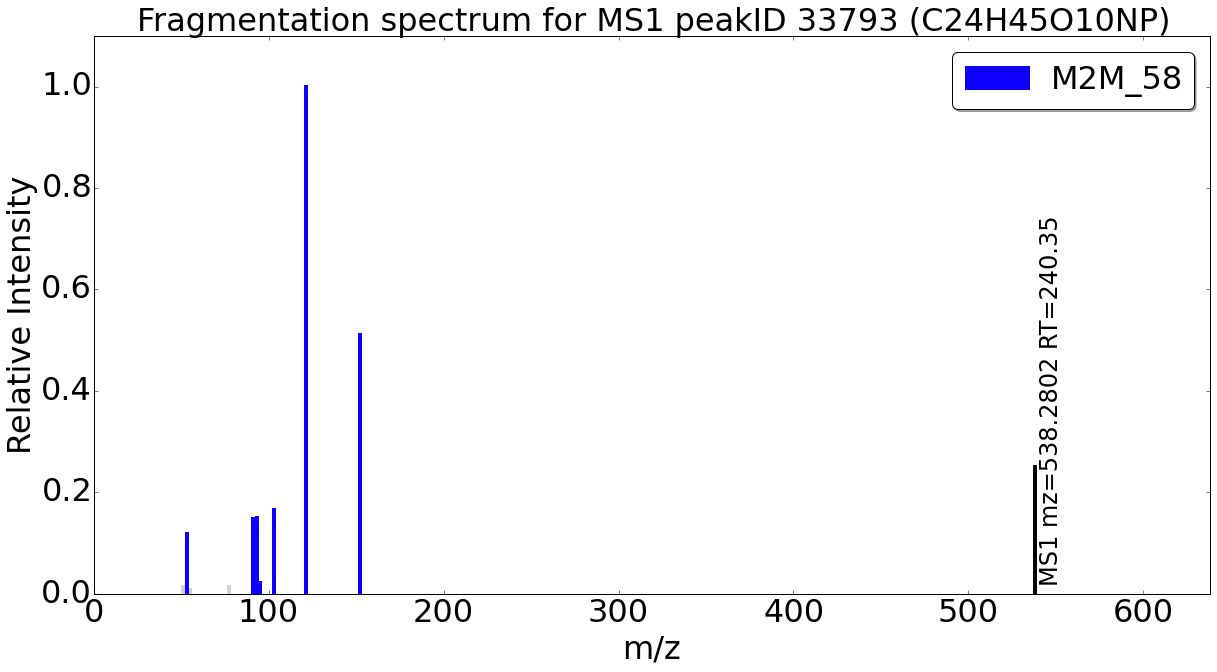

 - M2M_58	: Phenylacetaldehyde substructure (benzene ring with ethanol group attached)
		  fragment_121.06489 (0.412),fragment_103.05448 (0.103),fragment_93.06981 (0.082),fragment_53.03888 (0.080),fragment_91.05413 (0.071),fragment_152.10755 (0.027),loss_68.02601 (0.026),fragment_138.05067 (0.023),fragment_166.12292 (0.023),fragment_95.04936 (0.013),

Figure saved to figure_9c.pdf


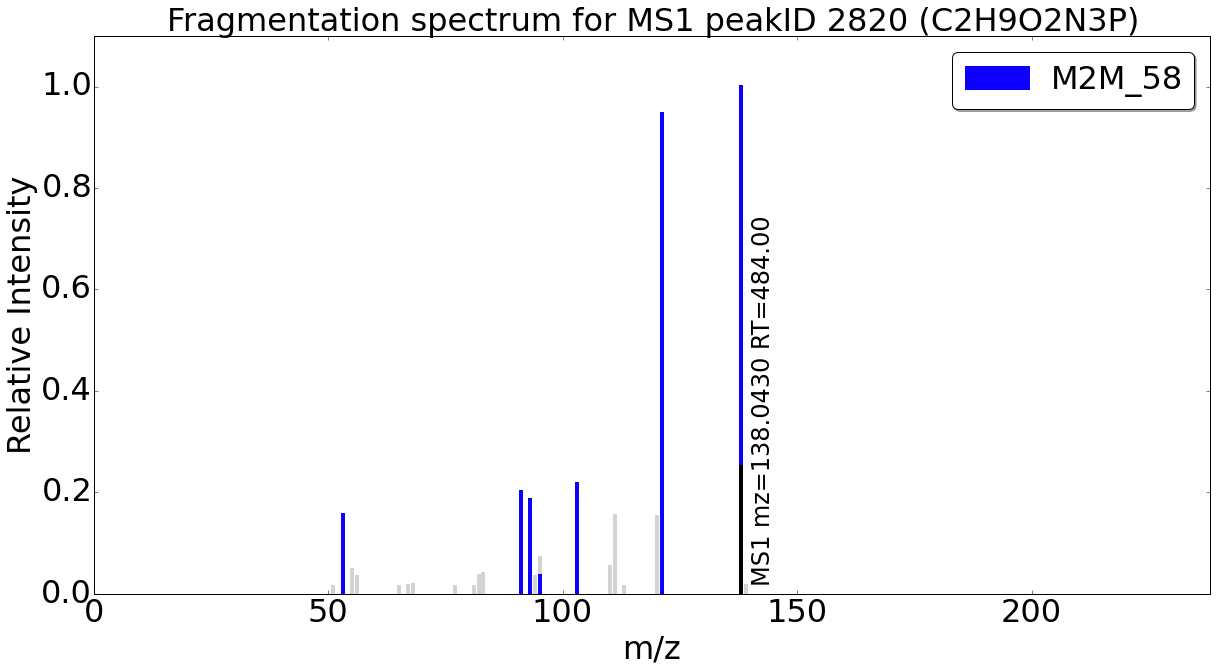

 - M2M_19	: Ferulic acid based substructure
		  fragment_177.05475 (0.191),fragment_89.03864 (0.146),fragment_145.02839 (0.137),fragment_117.03316 (0.115),fragment_364.22203 (0.035),fragment_149.05998 (0.028),fragment_307.17496 (0.027),loss_137.08402 (0.024),loss_130.12154 (0.024),loss_193.07267 (0.016),loss_176.10859 (0.016),fragment_100.07536 (0.013),fragment_171.1487 (0.012),fragment_134.03657 (0.012),fragment_78.04655 (0.011),fragment_234.11111 (0.011),

Figure saved to figure_9d.pdf


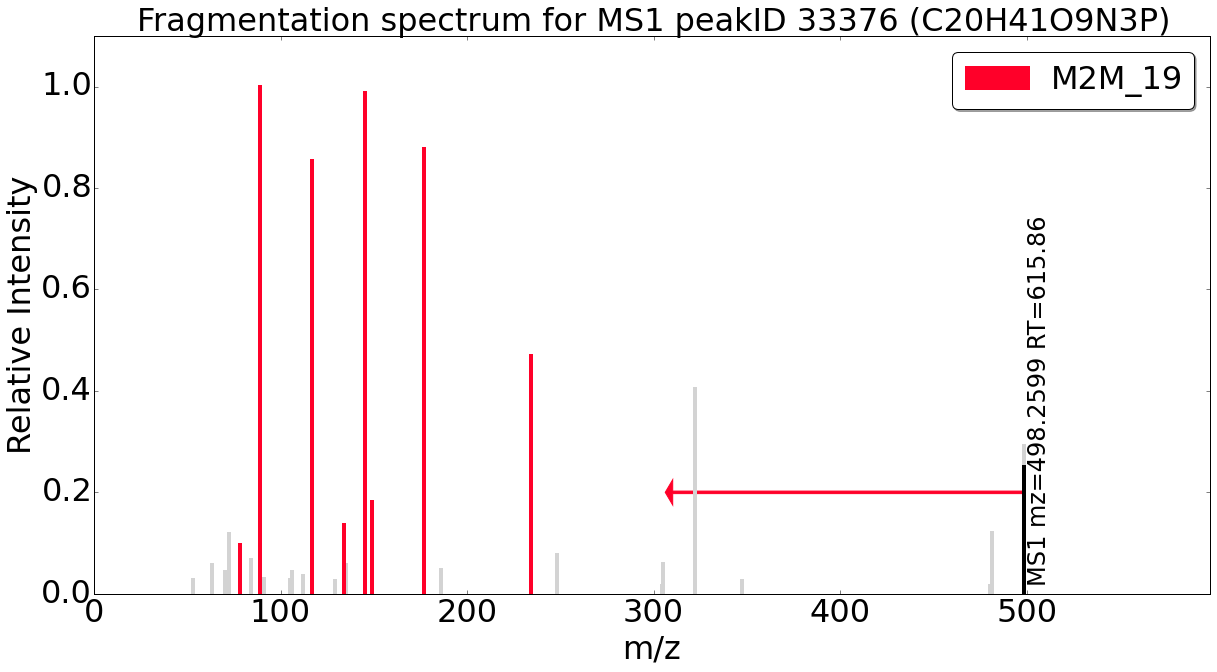

 - M2M_19	: Ferulic acid based substructure
		  fragment_177.05475 (0.191),fragment_89.03864 (0.146),fragment_145.02839 (0.137),fragment_117.03316 (0.115),fragment_364.22203 (0.035),fragment_149.05998 (0.028),fragment_307.17496 (0.027),loss_137.08402 (0.024),loss_130.12154 (0.024),loss_193.07267 (0.016),loss_176.10859 (0.016),fragment_100.07536 (0.013),fragment_171.1487 (0.012),fragment_134.03657 (0.012),fragment_78.04655 (0.011),fragment_234.11111 (0.011),

Figure saved to figure_9e.pdf


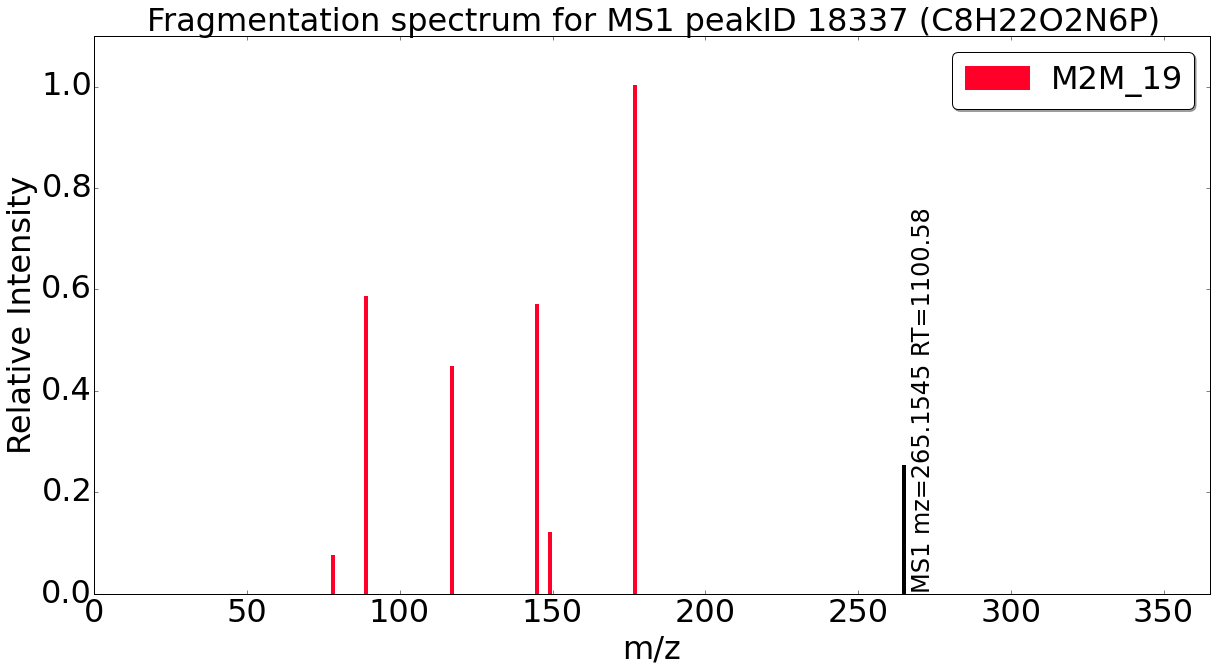

In [29]:
# print some fragmentation spectra
m2m_list = [58, 19]
ms1_list = [25054, 33793, 2820, 33376, 18337]

# loop over all ms1 in ms1_list
cc = 'a'
for i in range(len(ms1_list)):
    
    out_file = 'figure_9%s.pdf' % cc
    cc = chr(ord(cc) + 1)

    ms1 = ms1_list[i]
    df = print_report(ms2lda, G, ms1, motif_annotation, motif_words, motif_colour, motif_idx, word_map, 
                      save_to=out_file, xlim_upper=300, plotting_func=plot_fragmentation_spectrum)
    # display(df) # show the table to see the mz, annotations, etc

Figure saved to figure_9f.pdf


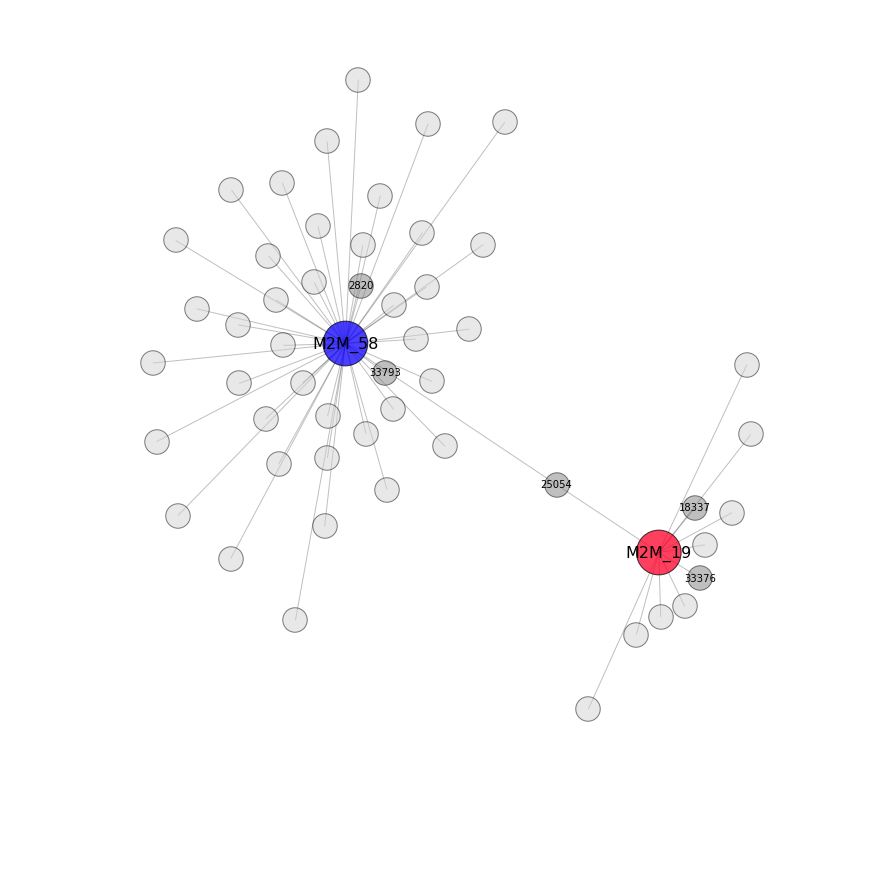

In [30]:
# plot the network for these nodes
plot_subgraph(G, m2m_list, ms1_list, motif_idx, motif_colour, save_to='figure_9f.pdf')